In [1]:
import torch as th
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#pipeline = tv.transforms.Compose([tv.transforms.ToTensor(),tv.transforms.Lambda(lambda x: x.reshape(-1)),])
#ds_train = tv.datasets.MNIST(root='.', transform=pipeline, download=True)
#ds_test = tv.datasets.MNIST(root='.', train=False, transform=pipeline, download=True)
ds_train = tv.datasets.MNIST(root='.', download=True)
ds_test = tv.datasets.MNIST(root='.', train=False, download=True)

In [3]:
np_x_train = np.array([np.array(x[0]) for x in ds_train])
np_x_test = np.array([np.array(x[0]) for x in ds_test])


In [4]:
np_x_train = np_x_train / 255.
np_x_test = np_x_test / 255.

In [5]:
# re-prep the datasets
ds_train = th.utils.data.TensorDataset(th.tensor(np_x_train.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))
ds_test = th.utils.data.TensorDataset(th.tensor(np_x_test.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))

torch.Size([1024, 784])

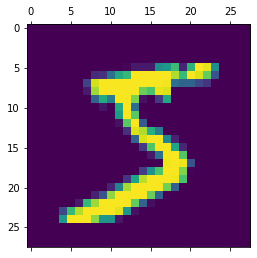

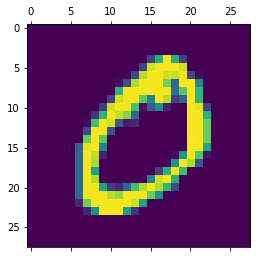

In [6]:
BATCH_SIZE = 1024
dl = th.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)
for x, in dl:
    break
plt.matshow(x[0].cpu().numpy().reshape(28,28))
plt.matshow(x[1].cpu().numpy().reshape(28,28))
x.shape

In [7]:
dl_test = th.utils.data.DataLoader(ds_test, batch_size=16)

for th_sample, in dl_test:
    break

In [8]:
print(len(dl))
print(x.device)

59
cuda:0


In [9]:
class SimpleAutoEncoder(th.nn.Module):
    def __init__(self, inp_size, encoding=[512, 256], embedding_size=32):
        super().__init__()
        self.enc_layers = th.nn.ModuleList()
        prev_units = inp_size
        for units in encoding:
            self.enc_layers.append(th.nn.Linear(prev_units, units))
            self.enc_layers.append(th.nn.ReLU())
            prev_units = units
            
        self.embedding = th.nn.Linear(prev_units, embedding_size)

        prev_units = embedding_size
        self.dec_layers = th.nn.ModuleList()
        for units in reversed(encoding):
            self.dec_layers.append(th.nn.Linear(prev_units, units))
            prev_units = units
            self.dec_layers.append(th.nn.ReLU())
        
        self.readout = th.nn.Linear(prev_units, inp_size)
        return
        
    def encoder(self, inputs):
        if len(inputs.shape) > 2: 
            # do NOT use this approach in real-life models.
            # instead use pre-processing reshaping (via tv pre-proc pipeline or manual)
            th_x = inputs.view(inputs.shape[0], -1)
        else:
            th_x = inputs
            
        for layer in self.enc_layers:
            th_x = layer(th_x)
        return self.embedding(th_x)
    
    def decoder(self, inputs):
        th_x = inputs
        for layer in self.dec_layers:
            th_x = layer(th_x)
        return self.readout(th_x)
    
    def forward(self, inputs):
        th_x = self.encoder(inputs)
        return self.decoder(th_x)
    
model = SimpleAutoEncoder(28*28).cuda()
model        

SimpleAutoEncoder(
  (enc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (embedding): Linear(in_features=256, out_features=32, bias=True)
  (dec_layers): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (readout): Linear(in_features=512, out_features=784, bias=True)
)

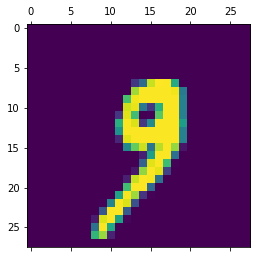

In [10]:
plt.matshow(ds_test[1000][0].cpu().numpy().reshape(28,28))

In [11]:
def th_eval(model):
    model.eval()
    with th.no_grad():
        th_yh = model(th_sample)
    plt.figure()
    plt.subplot(121)    
    gold_grid = tv.utils.make_grid(th_sample.view(16,1,28,28), nrow=4)
    np_gold_img = gold_grid.cpu().numpy().transpose(1,2,0)    
    plt.imshow(np_gold_img)
    
    plt.subplot(122)    
    pred_grid = tv.utils.make_grid(th_yh.view(16,1,28,28), nrow=4)
    np_pred_img = pred_grid.cpu().numpy().transpose(1,2,0)    
    plt.imshow(np_pred_img)
    plt.show()
    model.train()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


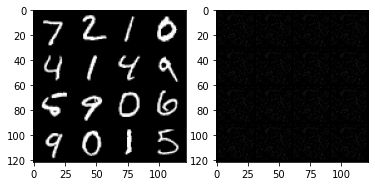

In [12]:
th_eval(model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


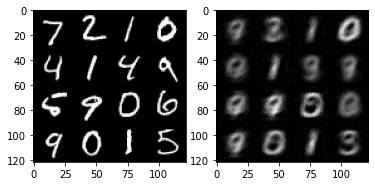

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


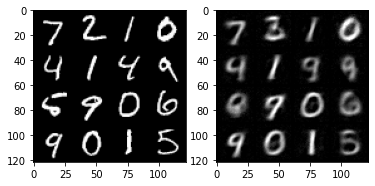

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


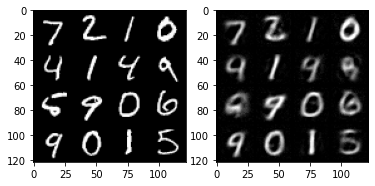

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


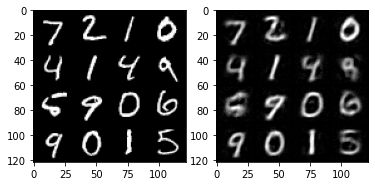

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


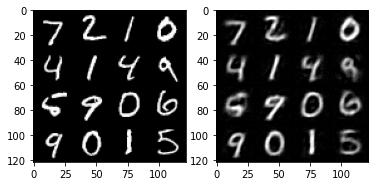

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


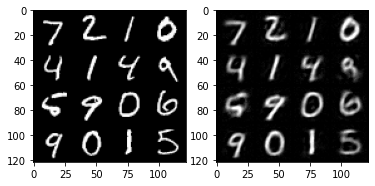

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


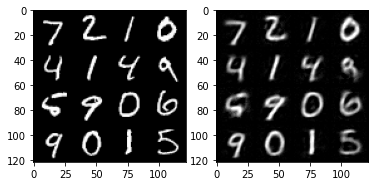

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


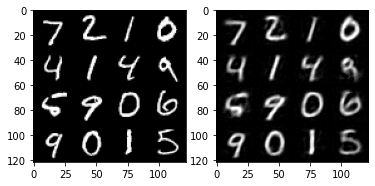

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


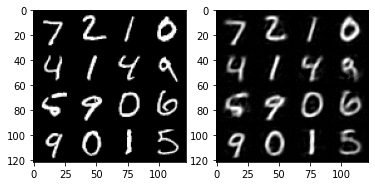

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


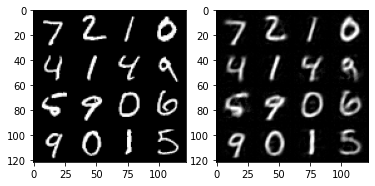

In [14]:
loss_fn = th.nn.MSELoss()
model = SimpleAutoEncoder(28*28).cuda()
opt = th.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 10
th_l1 = next(model.parameters())
for epoch in range(EPOCHS):
    cnt = 0
    for th_x_batch,  in dl:
        cnt += 1
        th_y_pred = model(th_x_batch)
        opt.zero_grad()
        th_loss = loss_fn(input=th_y_pred, target=th_x_batch.view(th_x_batch.shape[0], -1))
        th_loss.backward()
        opt.step()
    th_eval(model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


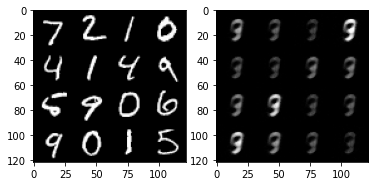

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


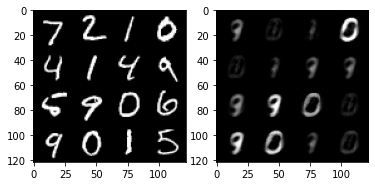

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


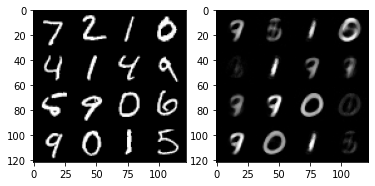

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


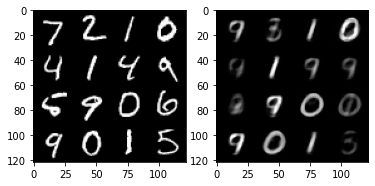

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


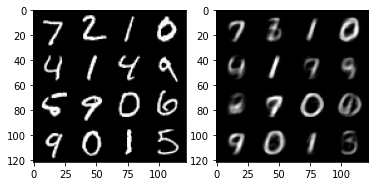

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


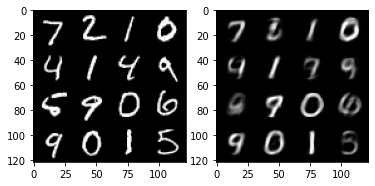

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


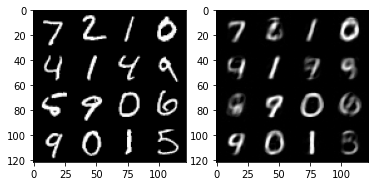

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


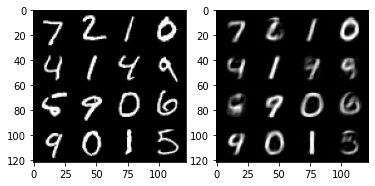

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


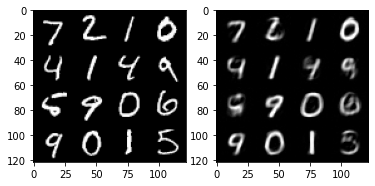

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


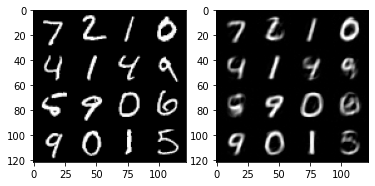

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


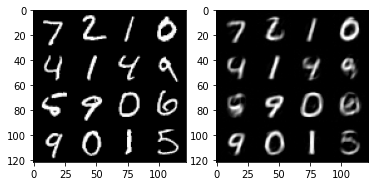

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


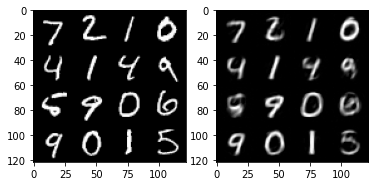

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


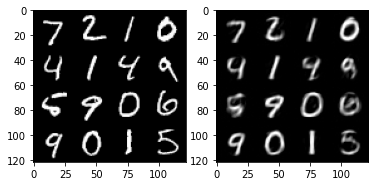

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


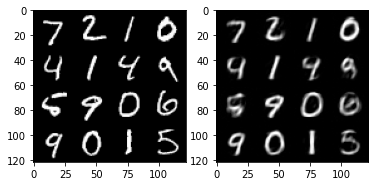

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


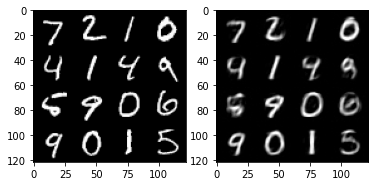

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


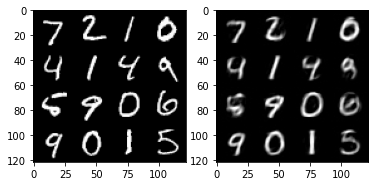

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


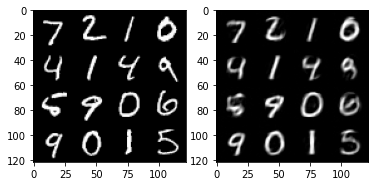

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


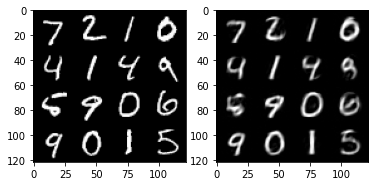

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


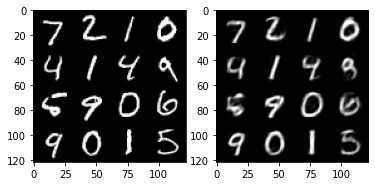

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


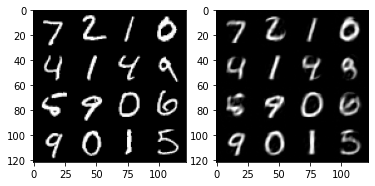

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


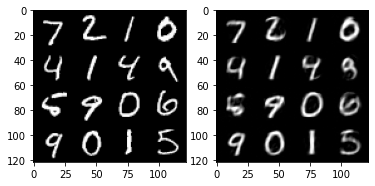

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


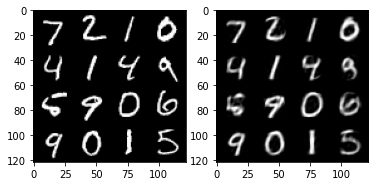

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


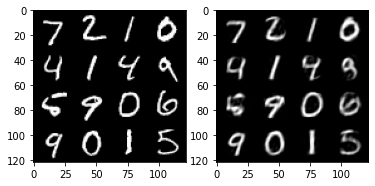

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


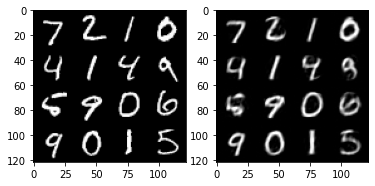

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


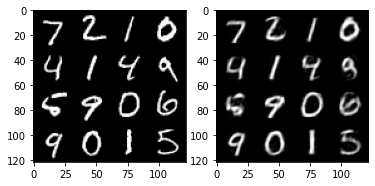

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


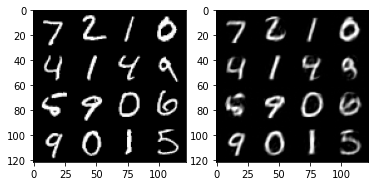

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


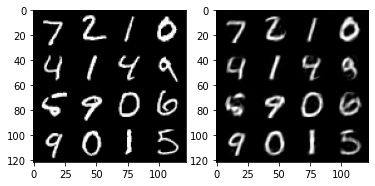

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


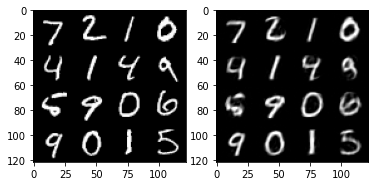

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


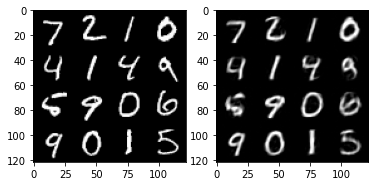

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


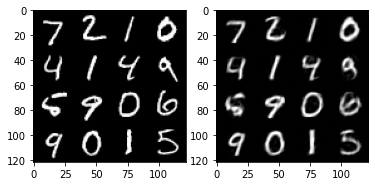

In [17]:
loss_fn = th.nn.L1Loss()
model = SimpleAutoEncoder(28*28).cuda()
opt = th.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 30
th_l1 = next(model.parameters())
for epoch in range(EPOCHS):
    cnt = 0
    for th_x_batch,  in dl:
        cnt += 1
        th_y_pred = model(th_x_batch)
        opt.zero_grad()
        th_loss = loss_fn(input=th_y_pred, target=th_x_batch.view(th_x_batch.shape[0], -1))
        th_loss.backward()
        opt.step()
    th_eval(model)
    
        

In [18]:
# TODO:
# try with Sigmoid/BCE
# add dropout
# test encoding
# test decoding



## Denoising auto encoders

In [19]:
class SimpleDenoiseAutoEncoder(th.nn.Module):
    def __init__(self, inp_size, encoding=[512, 256], embedding_size=32, drop_rate=0.7):
        super().__init__()
        self.noise_layer = th.nn.Dropout(drop_rate)
        self.enc_layers = th.nn.ModuleList()
        prev_units = inp_size
        for units in encoding:
            self.enc_layers.append(th.nn.Linear(prev_units, units))
            self.enc_layers.append(th.nn.ReLU())
            prev_units = units
        self.embedding = th.nn.Linear(prev_units, embedding_size)

        prev_units = embedding_size
        self.dec_layers = th.nn.ModuleList()
        for units in reversed(encoding):
            self.dec_layers.append(th.nn.Linear(prev_units, units))
            prev_units = units
            self.dec_layers.append(th.nn.ReLU())
        
        self.readout = th.nn.Linear(prev_units, inp_size)
        return
        
    def encoder(self, inputs):
        if len(inputs.shape) > 2: 
            # do NOT use this approach in real-life models.
            # instead use pre-processing reshaping (via tv pre-proc pipeline or manual)
            th_x = inputs.view(inputs.shape[0], -1)
        else:
            th_x = inputs
        th_x = self.noise_layer(th_x)
        for layer in self.enc_layers:
            th_x = layer(th_x)
        return self.embedding(th_x)
    
    def decoder(self, inputs):
        th_x = inputs
        for layer in self.dec_layers:
            th_x = layer(th_x)
        return self.readout(th_x)
    
    def forward(self, inputs):
        th_x = self.encoder(inputs)
        return self.decoder(th_x)
model = SimpleDenoiseAutoEncoder(28*28).cuda()
model        


SimpleDenoiseAutoEncoder(
  (noise_layer): Dropout(p=0.7, inplace=False)
  (enc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (embedding): Linear(in_features=256, out_features=32, bias=True)
  (dec_layers): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (readout): Linear(in_features=512, out_features=784, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


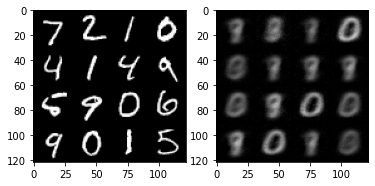

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


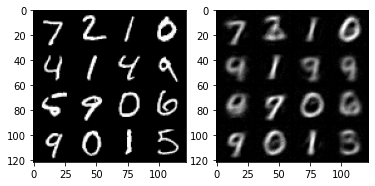

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


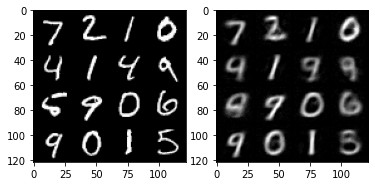

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


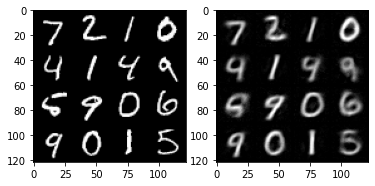

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


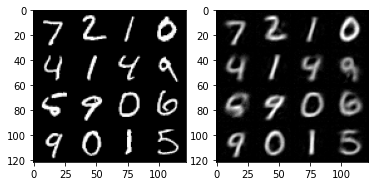

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


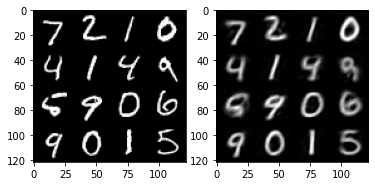

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


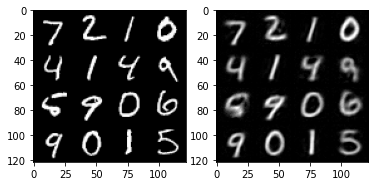

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


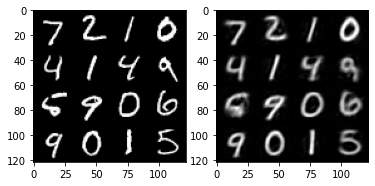

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


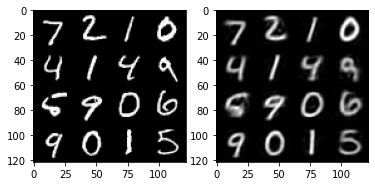

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


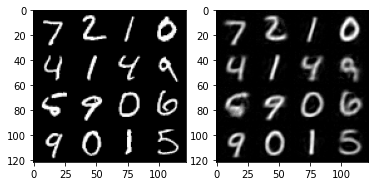

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


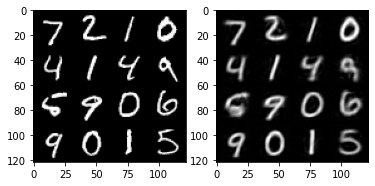

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


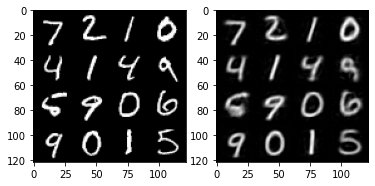

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


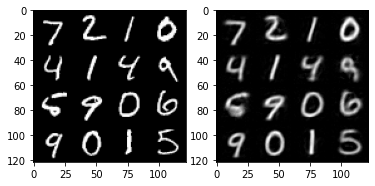

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


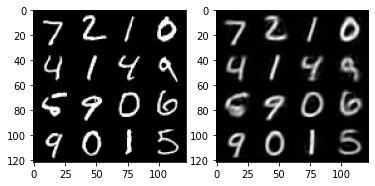

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


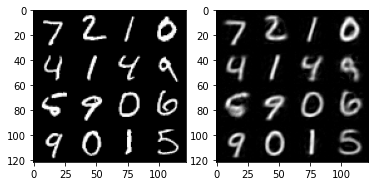

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


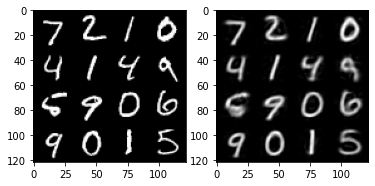

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


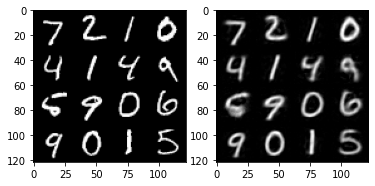

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


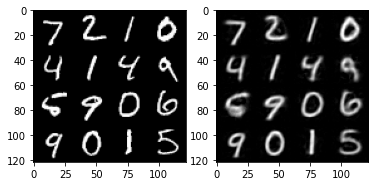

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


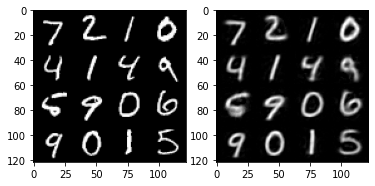

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


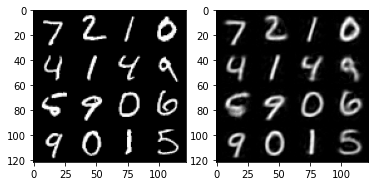

In [20]:
loss_fn = th.nn.MSELoss()
model = SimpleDenoiseAutoEncoder(28*28).cuda()
opt = th.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 20
th_l1 = next(model.parameters())
for epoch in range(EPOCHS):
    cnt = 0
    for th_x_batch,  in dl:
        cnt += 1
        th_y_pred = model(th_x_batch)
        opt.zero_grad()
        th_loss = loss_fn(input=th_y_pred, target=th_x_batch.view(th_x_batch.shape[0], -1))
        th_loss.backward()
        opt.step()
    th_eval(model)

In [21]:

th_sample = th_sample.reshape(16,1,28,28)
print(th_sample.shape)
noise = np.random.choice([0,1], size=(16,1,28,28), p=[0.7, 0.3])
th_bad_sample = th_sample * th.tensor(noise, device=th.device('cuda'))

torch.Size([16, 1, 28, 28])


In [22]:
grid = tv.utils.make_grid(th_sample, nrow=4)
bad_grid = tv.utils.make_grid(th_bad_sample, nrow=4)

In [23]:
np_img = grid.cpu().numpy().transpose(1,2,0)
np_bad_img= bad_grid.cpu().numpy().transpose(1,2,0)
np_img.shape

(122, 122, 3)

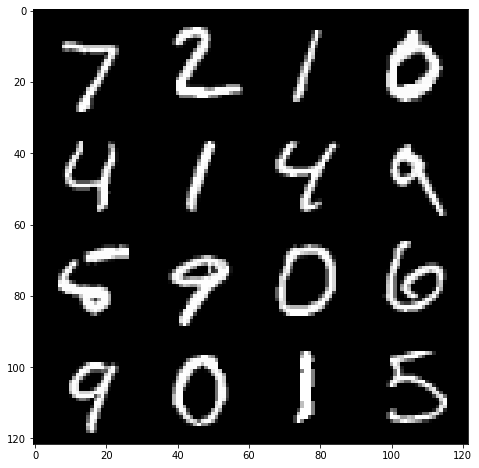

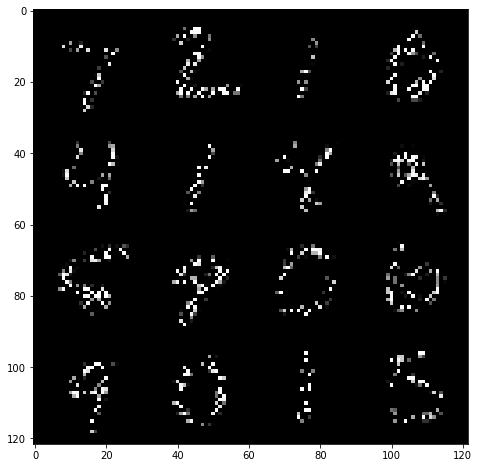

In [24]:
plt.figure(figsize=(13,8))
plt.imshow(np_img)
plt.figure(figsize=(13,8))
plt.imshow(np_bad_img)

In [25]:
model.eval()
with th.no_grad():
    th_pred = model(th_bad_sample.view(16, 28*28))
model.train()

SimpleDenoiseAutoEncoder(
  (noise_layer): Dropout(p=0.7, inplace=False)
  (enc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (embedding): Linear(in_features=256, out_features=32, bias=True)
  (dec_layers): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (readout): Linear(in_features=512, out_features=784, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


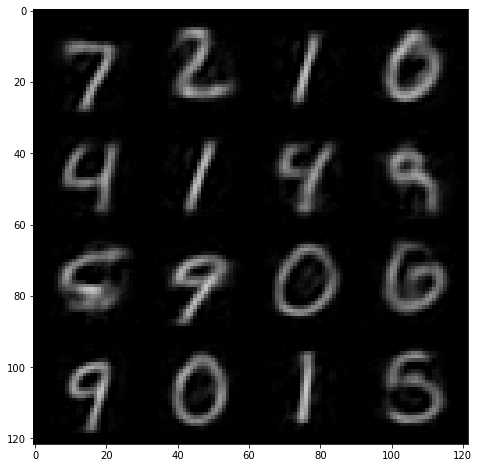

In [26]:
pred_grid = tv.utils.make_grid(th_pred.view(16,1,28,28), nrow=4)
np_pred_img = pred_grid.cpu().numpy().transpose(1,2,0)
plt.figure(figsize=(13,8))
plt.imshow(np_pred_img)

In [27]:
ds_test[:100][0].shape

torch.Size([100, 784])

In [ ]:
# TODO:
# add BCE
# add dropout
# test encoding
# test decoding